# EbayesThresh Python화 시도

SEOYEON CHOI  
2024-06-01

ref

-   [R_ebayesthresh](https://cran.r-project.org/web/packages/EbayesThresh/EbayesThresh.pdf)
-   [교수님
    블로그](https://guebin.github.io/STML2022/posts/II.%20DNN/2022-10-12-6wk.html#%EC%8B%9C%EB%B2%A4%EC%BD%94%EC%A0%95%EB%A6%AC)

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ebayesthresh

## import for code check

In [2]:
from scipy.stats import norm, stats
from scipy.optimize import minimize, root_scalar
from statsmodels.robust.scale import mad
import pywt

# beta.cauchy

> Function beta for the quasi-Cauchy prior

-   Description

> Given a value or vector x of values, find the value(s) of the function
> $\beta(x) = g(x)/\phi(x) − 1$, where $g$ is the convolution of the
> quasi-Cauchy with the normal density $\phi(x)$.

*x가 입력되면 코시 분포와 정규 분포를 혼합해서 함수 베타 구하기*

In [3]:
x = np.array([-2,1,0,-4,8,50])

In [4]:
phix = norm.pdf(x)
phix

-   x의 확률밀도함수pdf 구하기

In [5]:
j = (x != 0)
j

-   0이 아닌 인덱스만 얻기

In [6]:
beta = x
beta

In [7]:
beta = np.where(j == False, -1/2, beta)
beta

-   j가 False 즉 0이면 -1/2를 넣고 아니면 beta값 그대로 넣기

In [8]:
beta[j] = (norm.pdf(0) / phix[j] - 1) / (x[j] ** 2) - 1
beta

  beta[j] = (norm.pdf(0) / phix[j] - 1) / (x[j] ** 2) - 1

-   0의 확률밀도함수pdf에서 x의 확률밀도함수phix로 나누어서 1을 빼고
    그것을 x 중 0이 아닌 값들에 제곱한 값으로 나눠 1을 빼기

-   $\beta(x) = \begin{cases} x & \text{ if } x = 0 \\ \frac{\frac{\phi(0)}{\phi(x)}-1}{x^2} - 1 & \\ \text{ if } x \ne 0\end{cases}$

-   R code

``` r
beta.cauchy <- function(x) {
#
#   Find the function beta for the mixed normal prior with Cauchy
#   tails.  It is assumed that the noise variance is equal to one.
#
    phix <- dnorm(x)
    j <- (x != 0)
    beta <- x
    beta[!j] <- -1/2
    beta[j] <- (dnorm(0)/phix[j] - 1)/x[j]^2 - 1
    return(beta)
}
```

**결과**

-   Python

In [9]:
ebayesthresh.beta_cauchy(np.array([-2,1,0,-4,8,50]))

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh/utils.py:21: RuntimeWarning: divide by zero encountered in divide
  beta[j] = (norm.pdf(0) / phix[j] - 1) / (x[j] ** 2) - 1

-   R

``` r
> beta.cauchy(c(-2,1,0,-4,8,50))
[1]  5.972640e-01 -3.512787e-01 -5.000000e-01  1.852474e+02  1.233796e+12           Inf
```

-   무한히 꼬리가 긴 분포를 가진 코시분포

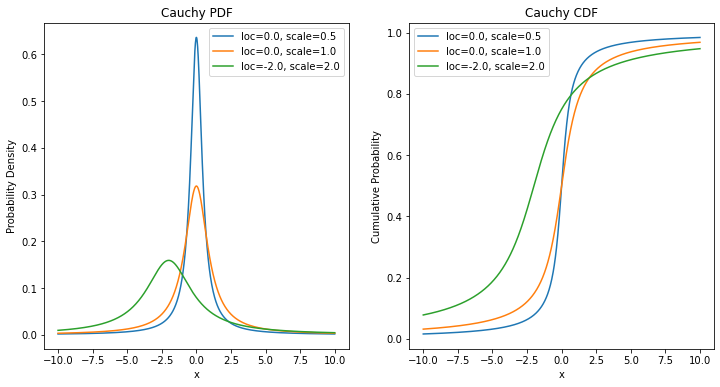

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

# 모수 설정
loc_values = [0.0, 0.0, -2.0]  # 위치 모수
scale_values = [0.5, 1.0, 2.0]  # 척도 모수

# 그래프 그리기
x = np.linspace(-10, 10, 1000)
plt.figure(figsize=(12, 6))

# PDF 그리기
plt.subplot(1, 2, 1)
for loc, scale in zip(loc_values, scale_values):
    plt.plot(x, cauchy.pdf(x, loc, scale), label=f'loc={loc}, scale={scale}')
plt.title('Cauchy PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# CDF 그리기
plt.subplot(1, 2, 2)
for loc, scale in zip(loc_values, scale_values):
    plt.plot(x, cauchy.cdf(x, loc, scale), label=f'loc={loc}, scale={scale}')
plt.title('Cauchy CDF')
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.show()

# beta.laplace

> Function beta for the Laplace prior

-   Description

> Given a single value or a vector of $x$ and $s$, find the value(s) of
> the function $\beta(x; s, a) = \frac{g(x; s, a)}{f_n(x; 0, s)}−1$,
> where $f_n(x; 0, s)$ is the normal density with mean $0$ and standard
> deviation $s$, and $g$ is the convolution of the Laplace density with
> scale parameter a, $γa(\mu)$, with the normal density $f_n(x; µ, s)$
> with mean mu and standard deviation $s$.

*평균이 $\mu$이며, 스케일 파라메터 a를 가진 라플라스와 정규분포의
합성함수 $g$와 평균이 0이고 표준편차가s인 f로 계산되는 함수 베타*

In [11]:
# x = np.array([-2,1,0,-4,8,50])
x = 2.14
s = 1
# s = np.arange(1, 7)
a = 0.5

-   s는 표준편차
-   a는 Laplaxe prior모수, 이 값이 클수록 부포 모양이 뾰족해진다.

In [12]:
x = np.abs(x)
x

-   확률변수 x에 절대값 취하고

In [13]:
xpa = x/s + s*a
xpa

In [14]:
xma = x/s - s*a
xma

In [15]:
rat1 = 1/xpa
rat1

In [16]:
xpa < 35

In [17]:
rat1[xpa < 35]

-   표준정규분포 누적 분포 함수cdf / 표준정규분포 밀도함수 pdf

In [18]:
if isinstance(rat1, (int, float, str, bool)) and xpa < 35:
    rat1 = norm.cdf(-xpa) / norm.pdf(xpa)
elif isinstance(rat1, (int, float, str, bool)) and xpa > 35:
    rat1 = rat1
else:
    rat1[xpa < 35] = norm.cdf(-xpa[xpa < 35]) / norm.pdf(xpa[xpa < 35])

In [19]:
rat1

In [20]:
rat2 = 1/np.abs(xma)
rat2

In [21]:
if isinstance(xma, (int, float, str, bool)) and xma > 35:
    xma = 35
elif isinstance(xma, (int, float, str, bool)) and xma < 35:
    xma = xma
else:
    xma[xma > 35] = 35

In [22]:
xma

In [23]:
if isinstance(rat1, (int, float, str, bool)) and xma > -35:
    rat2 = norm.cdf(xma) / norm.pdf(xma)
elif isinstance(rat1, (int, float, str, bool)) and xma < -35:
    rat2 = rat2
else:
    rat2[xma > -35] = norm.cdf(xma[xma > -35]) / norm.pdf(xma[xma > -35])

In [24]:
rat2

-   beta = $\frac{g(x; s, a)}{f_n(x; 0, s)}−1$
-   g = 스케일 파라메터 a를 가진 라플라스 밀도의 convolution +
    $\gamma (u ; a)$
    -   단, The Laplace density is given by
        $\gamma (u ; a) = \frac{1}{2} a e^{-a |u|}$ and is also known as
        the double exponential density.

In [25]:
beta = (a * s) / 2 * (rat1 + rat2) - 1
beta

-   R code

``` r
beta.laplace <- function(x, s = 1, a = 0.5) {
#
#  The function beta for the Laplace prior given parameter a and s (sd)
#
    x <- abs(x)
    xpa <- x/s + s*a
    xma <- x/s - s*a
    rat1 <- 1/xpa
    rat1[xpa < 35] <- pnorm( - xpa[xpa < 35])/dnorm(xpa[xpa < 35])
    rat2 <- 1/abs(xma)
    xma[xma > 35] <- 35
    rat2[xma > -35] <- pnorm(xma[xma > -35])/dnorm(xma[xma > -35])
    beta <- (a * s) / 2 * (rat1 + rat2) - 1
    return(beta)
}
```

**결과**

-   Python

In [26]:
ebayesthresh.beta_laplace(np.array([-2,1,0,-4,8,50]),s=1)

In [27]:
ebayesthresh.beta_laplace(-2,s=1,a=0.5)

In [28]:
ebayesthresh.beta_laplace(np.array([-2,1,0,-4,8,50]),s=np.arange(1, 7))

-   R

``` r
> beta.laplace(c(-2,1,0,-4,8,50), s=1)
[1]   8.898520e-01  -3.800417e-01  -5.618178e-01   2.854595e+02   1.026981e+12  6.344540e+265
> beta.laplace(-2, s=1, a=0.5)
[1] 0.889852
> beta.laplace(c(-2,1,0,-4,8,50), s=1:6, a=1)
[1]   0.890821055  -0.129919250  -0.086229104  -0.005203193   0.054213718 112.493576777
```

라플라스 분포, 정규분포와 유사한 모습, 하지만 중간이 뾰족한 모형

$f(x) = \frac{1}{2b} \exp \big[ \frac{-|x - \mu|}{b} \big]$

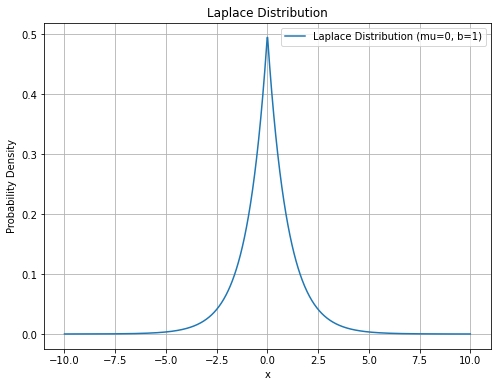

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 라플라스 분포의 확률 밀도 함수 정의
def laplace_pdf(x, mu, b):
    return 1/(2*b) * np.exp(-np.abs(x - mu) / b)

# 파라미터 설정
mu = 0  # 평균
b = 1   # 스케일 파라미터

# x 값 생성
x_values = np.linspace(-10, 10, 1000)

# 라플라스 분포의 확률 밀도 함수 계산
pdf_values = laplace_pdf(x_values, mu, b)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf_values, label=f'Laplace Distribution (mu={mu}, b={b})')
plt.title('Laplace Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# cauchy_medzero

> the objective function that has to be zeroed, component by component,
> to find the posterior median when the quasi-Cauchy prior is used. x is
> the parameter vector, z is the data vector, w is the weight x and z
> may be scalars

-   quasi-Cauchy prior에서 사후 중앙값 찾기 위한 함수
-   x,z는 벡터일수도 있고, 스칼라일 수 도 있다.

In [30]:
# x = np.array([-2,1,0,-4,8,50])
x = 4
# z = np.array([1,0,2,3,-1,-1])
z = 5
w = 0.5

In [31]:
hh = z - x
hh

In [32]:
dnhh = norm.pdf(hh)
dnhh

In [33]:
yleft = norm.cdf(hh) - z * dnhh + ((z * x - 1) * dnhh * norm.cdf(-x)) / norm.pdf(x)
yleft

In [34]:
yright2 = 1 + np.exp(-z**2 / 2) * (z**2 * (1 / w - 1) - 1)
yright2

In [35]:
yright2 / 2 - yleft

-   R코드

``` r
cauchy.medzero <- function(x, z, w) {
#    
# the objective function that has to be zeroed, component by
# component, to find the posterior median when the quasi-Cauchy prior
# is used.  x is the parameter vector, z is the data vector, w is the
# weight x and z may be scalars
#
    hh <- z - x
    dnhh <- dnorm(hh)
    yleft <- pnorm(hh) - z * dnhh + ((z * x - 1) * dnhh * pnorm( - x))/
        dnorm(x)
    yright2 <- 1 + exp( - z^2/2) * (z^2 * (1/w - 1) - 1)
    return(yright2/2 - yleft)
}
```

**결과**

-   Python
    -   벡터, 스칼라일때 가능한지 확인

In [36]:
ebayesthresh.cauchy_medzero(np.array([-2,1,0,-4,8,50]),np.array([1,0,2,3,-1,-1]),0.5)

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh/utils.py:203: RuntimeWarning: invalid value encountered in divide
  yleft = norm.cdf(hh) - z * dnhh + ((z * x - 1) * dnhh * norm.cdf(-x)) / norm.pdf(x)

In [37]:
ebayesthresh.cauchy_medzero(4,5,0.5)

-   R

``` r
> cauchy.medzero(c(-2,1,0,-4,8,50),c(1,0,2,3,-1,-1),0.5)
[1] -0.25356559  0.00000000 -0.09859737 -0.45556313  0.50000000         NaN
> cauchy.medzero(4,5,0.5)
[1] -0.2194424
```

# cauchy_threshzero

-   cauchy 임계값 찾기 위한 것
-   아래에서 반환되는 y가 0에 가깝도록 만들어주는 z를 찾는 과정

In [38]:
z = np.array([1,0,2,3,-1,-1])
# z = 0
# w = 0.5
w = np.array([0.5,0.4,0.3,0.2,0,0.1])

In [39]:
if isinstance(z, (list)):
    z = np.array(z)

In [40]:
y = norm.cdf(z) - z * norm.pdf(z) - 1/2 - (z**2 * np.exp(-z**2/2) * (1/w - 1))/2
y

  y = norm.cdf(z) - z * norm.pdf(z) - 1/2 - (z**2 * np.exp(-z**2/2) * (1/w - 1))/2

$y = pnorm(z) - z \times dnorm(z) - \frac{1}{2} - \frac{z^2 \exp (\frac{z^2}{2})(\frac{1}{w} - 1)}{2}$

-   R 코드

``` r
cauchy.threshzero <- function(z, w) {
#    
# The objective function that has to be zeroed to find the Cauchy
# threshold. z is the putative threshold vector, w is the weight w
# can be a vector
#
    y <- pnorm(z) - z * dnorm(z) - 1/2 -
         (z^2 * exp( - z^2/2) * (1/w - 1))/2
    return(y)
}
```

**결과**

-   Python

In [41]:
ebayesthresh.cauchy_threshzero(np.array([1,0,2,3,-1,-1]),0.5)

In [42]:
ebayesthresh.cauchy_threshzero(np.array([1,0,2,3,-1,-1]),np.array([0.5,0.4,0.3,0.2,0,0.1]))

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh/utils.py:211: RuntimeWarning: divide by zero encountered in divide
  y = norm.cdf(z) - z * norm.pdf(z) - 1/2 - (z**2 * np.exp(-z**2/2) * (1/w - 1))/2

-   R

``` r
> cauchy.threshzero(c(1,0,2,3,-1,-1),0.5)
[1] -0.20389131  0.00000000  0.09859737  0.43536407 -0.40263935 -0.40263935
cauchy.threshzero(c(1,0,2,3,-1,-1), c(0.5,0.4,0.3,0.2,0,0.1))
[1] -0.2038913  0.0000000 -0.2622967  0.2853926       -Inf -2.8287620
```

# ebayesthresh

In [2]:
x = np.concatenate([np.random.normal(0, 1, 90), np.random.normal(5, 1, 10)])
sdev = 1
prior="laplace"
a=0.5
bayesfac=False
verbose=False
threshrule="median"
universalthresh=True
stabadjustment=None

In [3]:
pr = prior[0:1]
pr

In [45]:
if sdev is None:
    sdev = ebayesthresh.mad(x, center=0)
    stabadjustment_condition = True
elif len(np.atleast_1d(sdev)) == 1:
    if stabadjustment is not None:
        raise ValueError("Argument stabadjustment is not applicable when variances are homogeneous.")
    if np.isnan(sdev):
        sdev = ebayesthresh.mad(x, center=0)
    stabadjustment_condition = True
else:
    if pr == "c":
        raise ValueError("Standard deviation has to be homogeneous for Cauchy prior.")
    if len(sdev) != len(x):
        raise ValueError("Standard deviation has to be homogeneous or have the same length as observations.")
    if stabadjustment is None:
        stabadjustment = False
    stabadjustment_condition = stabadjustment

In [46]:
stabadjustment_condition

In [47]:
if stabadjustment_condition:
    m_sdev = np.mean(sdev)
    s = sdev / m_sdev
    x = x / m_sdev
else:
    s = sdev

In [48]:
a

In [49]:
if (pr == "l") and np.isnan(a):
    pp = ebayesthresh.wandafromx(x, s, universalthresh)
    w = pp['w']
    a = pp['a']
else:
    w = ebayesthresh.wfromx(x, s, prior=prior, a=a, universalthresh=universalthresh)

In [50]:
w

In [51]:
a

In [52]:
s

In [53]:
if pr != "m" or verbose:
    tt = ebayesthresh.tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)[0]
    if stabadjustment_condition:
        tcor = tt * m_sdev
    else:
        tcor = tt

In [54]:
if threshrule == "median":
    muhat = ebayesthresh.postmed(x, s, w, prior=prior, a=a)
elif threshrule == "mean":
    muhat = ebayesthresh.postmean(x, s, w, prior=prior, a=a)
elif threshrule == "hard":
    muhat = ebayesthresh.threshld(x, tt)
elif threshrule == "soft":
    muhat = ebayesthresh.threshld(x, tt, hard=False)
elif threshrule == "none":
    muhat = None
else:
    raise ValueError(f"Unknown threshold rule: {threshrule}")

In [55]:
muhat

In [56]:
if stabadjustment_condition:
    muhat = muhat * m_sdev

In [57]:
muhat

In [58]:
if not verbose:
    muhat
else:
    retlist = {
        'muhat': muhat,
        'x': x,
        'threshold.sdevscale': tt,
        'threshold.origscale': tcor,
        'prior': prior,
        'w': w,
        'a': a,
        'bayesfac': bayesfac,
        'sdev': sdev,
        'threshrule': threshrule
    }
    if pr == "c":
        del retlist['a']
    if threshrule == "none":
        del retlist['muhat']
    retlist

R코드

``` r
ebayesthresh <- function (x, prior = "laplace", a = 0.5, bayesfac = FALSE,
                          sdev = NA, verbose = FALSE, threshrule = "median",
                          universalthresh = TRUE, stabadjustment) {
#  
#  Given a vector of data x, find the marginal maximum likelihood
#  estimator of the mixing weight w, and apply an appropriate
#  thresholding rule using this weight.
#
#  If the prior is laplace and a=NA, then the inverse scale parameter
#  is also found by MML.
#
#  Standard deviation sdev can be a vector (heterogeneous variance) or
#  a single value (homogeneous variance). If sdev=NA, then it is
#  estimated using the function mad(x). Heterogeneous variance is
#  allowed only for laplace prior currently.
#    
#  The thresholding rules allowed are "median", "mean", "hard", "soft"
#  and "none"; if "none" is used, then only the parameters are worked
#  out.
#
#  If hard or soft thresholding is used, the argument "bayesfac"
#  specifies whether to use the bayes factor threshold or the
#  posterior median threshold.
#    
#  If universalthresh=TRUE, the thresholds will be upper bounded by
#  universal threshold adjusted by standard deviation; otherwise,
#  weight w will be searched in [0, 1].
#    
#  If stabadjustment=TRUE, the observations and standard deviations
#  will be first divided by the mean of all given standard deviations
#  in case of inefficiency due to large value of standard
#  deviation. In the case of homogeneous variance, the standard
#  deviations will be normalized to 1 automatically.
#
#  If verbose=TRUE then the routine returns a list with several
#  arguments, including muhat which is the result of the
#  thresholding. If verbose=FALSE then only muhat is returned.
#
    
  # Find the standard deviation if necessary and estimate the parameters
  pr <- substring(prior, 1, 1)

  if(length(sdev) == 1) {
      if(!missing(stabadjustment))
        stop(paste("Argument stabadjustment is not applicable when",
                   "variances are homogeneous."))
      if(is.na(sdev)) {
          sdev <- mad(x, center = 0)
      }
      stabadjustment_condition = TRUE
  } else{
    if(pr == "c")
      stop("Standard deviation has to be homogeneous for Cauchy prior.")
    if(length(sdev) != length(x))
      stop(paste("Standard deviation has to be homogeneous or has the",
                 "same length as observations."))
    if(missing(stabadjustment))
      stabadjustment <- FALSE
    stabadjustment_condition = stabadjustment
  }
  
  if (stabadjustment_condition) {
    m_sdev <- mean(sdev)
    s <- sdev/m_sdev
    x <- x/m_sdev
  } else { s <- sdev }
  
    if ((pr == "l") & is.na(a)) {
      pp <- wandafromx(x, s, universalthresh)
          w  <- pp$w
          a  <- pp$a
    }
    else
          w <- wfromx(x, s, prior = prior, a = a, universalthresh)
    if(pr != "m" | verbose) {
      tt <- tfromw(w, s, prior = prior, bayesfac = bayesfac, a = a)
      if(stabadjustment_condition) {
        tcor <- tt * m_sdev
          } else {
            tcor <- tt
          }
    }
    if(threshrule == "median")
        muhat <- postmed(x, s, w, prior = prior, a = a)
    if(threshrule == "mean")
    muhat <- postmean(x, s, w, prior = prior, a = a)
    if(threshrule == "hard")
        muhat <- threshld(x, tt)
    if(threshrule == "soft")
        muhat <- threshld(x, tt, hard = FALSE)
        if(threshrule == "none")
                muhat <- NA

    # Now return desired output
    if(stabadjustment_condition) {
      muhat <- muhat * m_sdev
    }
    if(!verbose)
            return(muhat)
    retlist <- list(muhat = muhat, x = x, threshold.sdevscale = tt, 
                        threshold.origscale = tcor, prior = prior, w = w,
                        a = a, bayesfac = bayesfac, sdev = sdev,
                        threshrule = threshrule)
    if(pr == "c")
        retlist <- retlist[-7]
    if(threshrule == "none")
        retlist <- retlist[-1]
    return(retlist)
}
```

결과

-   Python

In [5]:
ebayesthresh.ebayesthresh(x=np.concatenate([np.random.normal(0, 1, 90), np.random.normal(5, 1, 10)]), sdev = 1)

-   R

``` r
> ebayesthresh(x = rnorm(100, c(rep(0,90), rep(5,10))),
+              prior = "laplace", sdev = 1)
  [1]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [15]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [29]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [43]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [57]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [71]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 -0.4480064
 [85]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  5.1534865  6.2732386  4.4612851  5.9931848  4.5828731  4.6154038  4.8247775  3.6219544
 [99]  4.4480080  5.4084453
```

# ebayesthresh.wavelet

R코드

``` r
ebayesthresh.wavelet <-
  function (xtr, vscale = "independent", smooth.levels = Inf,
            prior = "laplace", a = 0.5, bayesfac = FALSE,
            threshrule = "median") {
    xcl <- class(xtr)
    if (class(xcl) == "dwt " && length(xcl) > 1) {
            xtr <- ebayesthresh.wavelet.splus(xtr, vscale, smooth.levels,
                                              prior, a, bayesfac, threshrule)
            return(xtr)
        }
    if (xcl == "wd") {
            xtr <- ebayesthresh.wavelet.wd(xtr, vscale, smooth.levels, prior,
                                           a, bayesfac, threshrule)
            return(xtr)
        }
        if (xcl == "dwt" || xcl=="modwt") {
            xtr <- ebayesthresh.wavelet.dwt(xtr, vscale, smooth.levels,
                                            prior, a, bayesfac, threshrule)
            return(xtr)
        }
    stop("Unknown wavelet transform type; no smoothing performed")
    return(xtr)
}
```

결과

-   Python

-   R

``` r
```

# ebayesthresh.wavelet.dwt

In [12]:
data = np.concatenate([np.random.normal(0, 1, 90), np.random.normal(5, 1, 10)])
n = len(data)
level1 = data[::2] - data[1::2]
level2 = level1[::2] - level1[1::2]
approximation = level2[::2] + level2[::2]

# Create a list of wavelet coefficients for each level
x_dwt = [approximation, level2, level1]
x_dwt

In [13]:
# x_dwt
vscale="independent"
smooth_levels=float('inf')
prior="laplace"
a=0.5
bayesfac=False,
threshrule="median"

In [7]:
nlevs = len(x_dwt) - 1
nlevs

In [8]:
slevs = min(nlevs, smooth_levels)
slevs

In [18]:
if isinstance(vscale, str):
    vs = vscale[0].lower()
    if vs == "i":
        vscale = ebayesthresh.mad(x_dwt[0], center=0)
    if vs == "l":
        vscale = None

In [23]:
for j in range(slevs):
    x_dwt[j] = ebayesthresh.ebayesthresh(x_dwt[j], prior=prior, a=a, bayesfac=bayesfac, 
                            sdev=vscale, verbose=False, threshrule=threshrule)

Unexpected exception formatting exception. Falling back to standard exception

Traceback (most recent call last):
  File "/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-7fc60b3f848b>", line 2, in <cell line: 1>
    x_dwt[j] = EbayesThresh.ebayesthresh(x_dwt[j], prior=prior, a=a, bayesfac=bayesfac,
  File "/home/csy/Dropbox/sy_hub/posts/1_Note/EbayesThresh/utils.py", line 100, in ebayesthresh
    tt = tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)[0]
  File "/home/csy/Dropbox/sy_hub/posts/1_Note/EbayesThresh/utils.py", line 713, in tfromw
TypeError: object of type 'numpy.float64' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/csy/anaconda3/envs/te

In [24]:
x_dwt

R코드

``` r
ebayesthresh.wavelet.dwt <-
  function (x.dwt, vscale = "independent", smooth.levels = Inf, 
            prior = "laplace", a = 0.5, bayesfac = FALSE,
            threshrule = "median") {
        nlevs <- length(x.dwt)-1
        slevs <- min(nlevs, smooth.levels)
        if (is.character(vscale)) {
            vs <- substring(vscale, 1, 1)
            if (vs == "i") 
                vscale <- mad(x.dwt[[1]])
            if (vs == "l") 
                vscale <- NA
        }
        for (j in 1:slevs) {
            x.dwt[[j]] <-
              ebayesthresh(x.dwt[[j]], prior, a, bayesfac, vscale,
                           FALSE, threshrule)
        }
     return(x.dwt)
}
```

결과

-   Python

In [13]:
ebayesthresh.ebayesthresh_wavelet_dwt(x_dwt)

-   R

확인 불가

``` r
> ebayesthresh.wavelet.dwt(x.dwt=x_dwt)
Error in ebayesthresh.wavelet.dwt(x.dwt = x_dwt) : 
  could not find function "ebayesthresh.wavelet.dwt"
```

# ebayesthresh.wavelet.splus

In [7]:
data = np.concatenate([np.random.normal(0, 1, 90), np.random.normal(5, 1, 10)])
n = len(data)
level1 = data[::2] - data[1::2]
level2 = level1[::2] - level1[1::2]
approximation = level2[::2] + level2[::2]

# Create a list of wavelet coefficients for each level
x_dwt = [approximation, level2, level1]
x_dwt

In [5]:
vscale="independent"
smooth_levels=float('inf')
prior="laplace"
a=0.5
bayesfac=False
threshrule="median"

In [6]:
nlevs = len(x_dwt)
nlevs

In [7]:
slevs = min(nlevs, smooth_levels)
slevs

In [8]:
if isinstance(vscale, str):
    vs = vscale[0].lower()
    if vs == "i":
        vscale = ebayesthresh.mad(x_dwt[-1])  # Use the last level for vscale
    elif vs == "l":
        vscale = None

In [9]:
vscale

In [11]:
for j in range(nlevs - slevs + 1, nlevs + 1):
        x_dwt[j - 1] = ebayesthresh.ebayesthresh(x_dwt[j - 1], prior=prior, a=a, bayesfac=bayesfac, 
                                    sdev=vscale, verbose=False, threshrule=threshrule)

In [12]:
x_dwt

R코드

``` r
ebayesthresh.wavelet.splus <-
  function (x.dwt, vscale = "independent", smooth.levels = Inf, 
            prior = "laplace", a = 0.5, bayesfac = FALSE,
            threshrule = "median") {
        nlevs <- attributes(x.dwt)$n.levels
        slevs <- min(nlevs, smooth.levels)
        if (is.character(vscale)) {
            vs <- substring(vscale, 1, 1)
            if (vs == "i") 
                vscale <- mad(x.dwt[[nlevs + 1]])
            if (vs == "l") 
                vscale <- NA
        }
        for (j in ((nlevs - slevs + 2):(nlevs + 1)))
          x.dwt[[j]] <-
            ebayesthresh(as.vector(x.dwt[[j]]), prior, a, bayesfac,
                         vscale, FALSE, threshrule)
        return(x.dwt)
}
```

결과

-   Python

In [ ]:
ebayesthresh.ebayesthresh_wavelet_splus(x_dwt=x_dwt)

-   R

확인 불가

``` r
> ebayesthresh.wavelet.splus(x.dwt=x_dwt)
Error in ebayesthresh.wavelet.splus(x.dwt = x_dwt) : 
  could not find function "ebayesthresh.wavelet.splus"
```

# ebayesthresh.wavelet.wd

In [15]:
def get_mother_wavelet_coefficients(data, level):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(data, 'db1', level=level)
    
    # Access the coefficients at the desired resolution level
    mother_wavelet_coeffs = coeffs[level]
    
    return mother_wavelet_coeffs

# Example usage:
data = [1, 2, 3, 4, 5, 6, 7, 8]
level = 2
mother_wavelet_coeffs = get_mother_wavelet_coefficients(data, level)

In [16]:
mother_wavelet_coeffs

In [17]:
x_wd = pywt.Wavelet('db1')
x_wd

In [20]:
vscale="independent"
smooth_levels=float('inf')
prior="laplace"
a=0.5
bayesfac=False
threshrule="median"

In [ ]:
nlevs = x_wd['nlevels']
nlevs

In [ ]:
slevs = min(nlevs - 1, smooth_levels)
slevs

In [ ]:
if isinstance(vscale, str):
    vs = vscale[0].lower()
    if vs == "i":
        vscale = ebayesthresh.mad(get_mother_wavelet_coefficients(x_wd,-1))  # Use the last level for vscale
    elif vs == "l":
        vscale = None

In [ ]:
for j in range(nlevs - slevs, nlevs - 1):
        x_wd.d[j] = ebayesthresh(x_wd.d[j], prior=prior, a=a, bayesfac=bayesfac, 
                                  sdev=vscale, verbose=False, threshrule=threshrule)

In [ ]:
x_wd

R코드

``` r
ebayesthresh.wavelet.wd <-
  function (x.wd, vscale = "independent", smooth.levels = Inf,
            prior = "laplace", a = 0.5, bayesfac = FALSE,
            threshrule = "median") {
    nlevs <- x.wd$nlevels
    slevs <- min(nlevs - 1, smooth.levels)
    if (is.character(vscale)) {
        vs <- substring(vscale, 1, 1)
        if (vs == "i")
            vscale <- mad(accessD(x.wd, level = nlevs - 1))
        if (vs == "l")
            vscale <- NA
    }
    for (j in (nlevs - slevs):(nlevs - 1)) {
      x.wd <- putD(x.wd, level = j,
                   v = ebayesthresh(accessD(x.wd, level = j), prior, a,
                                    bayesfac, vscale, FALSE, threshrule))
    }
    return(x.wd)
}
```

결과

-   Python

In [ ]:
ebayesthresh.ebayesthresh_wavelet_wd(x_wd)

-   R

확인 불가

``` r
> ebayesthresh.wavelet.wd(x.dwt=x_dwt)
Error in ebayesthresh.wavelet.wd(x.dwt = x_dwt) : 
  could not find function "ebayesthresh.wavelet.wd"
```

# isotone

> Isotonic Regression은 입력 변수에 따른 출력 변수의 단조 증가(monotonic
> increasing) 또는 감소(monotonic decreasing) 패턴을 찾는 방법

In [60]:
beta = ebayesthresh.beta_cauchy(np.array([-2,1,0,-4]))
w = np.ones(len(beta))
aa = w + 1/beta
x = w + aa
wt = 1/aa**2
increasing = False

In [61]:
nn = len(x)

In [62]:
if nn == 1:
    x = x

In [63]:
if not increasing:
    x = -x

In [64]:
ip = np.arange(1, nn+1)
dx = np.diff(x)
nx = len(x)

In [65]:
jmax = np.arange(nx)[(np.concatenate((dx <= 0, [False])) & np.concatenate(([True], dx > 0)))]
jmin = np.arange(nx)[(np.concatenate((dx > 0, [True])) & np.concatenate(([False], dx <= 0)))]

In [66]:
jb=0
ind = np.arange(jmax[jb], jmin[jb]+1)
wtn = np.sum(wt[ind])

In [67]:
x[jmax[jb]] = np.sum(wt[ind] * x[ind]) / wtn

In [68]:
wt[jmax[jb]] = wtn

In [69]:
x[jmax[jb]+1:jmin[jb]+1] = np.nan

In [70]:
# Clean up within iteration, eliminating the parts of sequences that
# were set to NA
ind = ~np.isnan(x)
x = x[ind]
wt = wt[ind]
ip = ip[ind]
dx = np.diff(x)
nx = len(x)

In [71]:
# Final cleanup: reconstruct z at all points by repeating the pooled
# values the appropriate number of times
jj = np.zeros(nn, dtype=int)
jj[ip - 1] = 1
z = x[np.cumsum(jj) - 1]

In [72]:
if not increasing:
    z = -z

In [73]:
z

R코드

``` r
isotone <- function(x, wt = rep(1, length(x)), increasing = FALSE) {
#
#   find the weighted least squares isotone fit to the 
#   sequence x, the weights given by the sequence wt
#
#   if increasing == TRUE the curve is set to be increasing, 
#   otherwise to be decreasing
#
#   the vector ip contains the indices on the original scale of the
#   breaks in the regression at each stage
#
    nn <- length(x)
    if(nn == 1)
        return(x)
    if(!increasing)
        x <-  - x
    ip <- (1:nn)
    dx <- diff(x)
    nx <- length(x)
    while((nx > 1) && (min(dx) < 0)) {
#
#  do single pool-adjacent-violators step
#
#  find all local minima and maxima
#
        jmax <- (1:nx)[c(dx <= 0, FALSE) & c(TRUE, dx > 0)]
        jmin <- (1:nx)[c(dx > 0, TRUE) & c(FALSE, dx <= 0)]
#  do pav step for each pair of maxima and minima
#
#  add up weights within subsequence that is pooled
#  set first element of subsequence to the weighted average
#  the first weight to the sum of the weights within the subsequence
#    and remainder of the subsequence to NA
#
        for(jb in (1:length(jmax))) {
            ind <- (jmax[jb]:jmin[jb])
            wtn <- sum(wt[ind])
            x[jmax[jb]] <- sum(wt[ind] * x[ind])/wtn
            wt[jmax[jb]] <- wtn
            x[(jmax[jb] + 1):jmin[jb]] <- NA
        }
#
#  clean up within iteration, eliminating the parts of sequences that
#  were set to NA
#
        ind <- !is.na(x)
        x <- x[ind]
        wt <- wt[ind]
        ip <- ip[ind]
        dx <- diff(x)
        nx <- length(x)
    }
# 
#  final cleanup: reconstruct z at all points by repeating the pooled
#    values the appropriate number of times
#
    jj <- rep(0, nn)
    jj[ip] <- 1
    z <- x[cumsum(jj)]
    if(!increasing)
        z <-  - z
    return(z)
}
```

결과

-   Python

In [74]:
beta = ebayesthresh.beta_cauchy(np.array([-2,1,0,-4]))
w = np.ones(len(beta))
aa = w + 1/beta
ps = w + aa
ww = 1/aa**2
wnew = ebayesthresh.isotone(ps, ww, increasing = False)
wnew

R

``` r
> beta <- beta.cauchy(c(-2,1,0,-4))
> w <- rep(1, length(x))
> aa = w + 1/beta
> ps = w + aa
> ww = 1/aa**2
> wnew = isotone(ps, ww, increasing = FALSE)
> wnew
[1] 3.674301 0.760411 0.760411 0.760411
```

# laplace_threshzero

In [75]:
x = np.array([-2,1,0,-4,8,50])
s = 1
w = 0.5
a = 0.5

In [76]:
a = min(a, 20)
a

In [77]:
if isinstance(x, list):
    z = []
    for elem in x:
        xma = elem / s - s * a
        z_add = norm.cdf(xma) - (1 / a) * (1 / s * norm.pdf(xma)) * (1 / w + ebayesthresh.beta_laplace(elem, s, a))
        z.append(z_add)
else:
    xma = x / s - s * a
    z = norm.cdf(xma) - (1 / a) * (1 / s * norm.pdf(xma)) * (1 / w + ebayesthresh.beta_laplace(x, s, a))

In [78]:
xma

In [79]:
z

R코드

``` r
laplace.threshzero <- function(x, s = 1, w = 0.5, a = 0.5) {
#
# The function that has to be zeroed to find the threshold with the
# Laplace prior.  Only allow a < 20 for input value.
#    
  a <- min(a, 20)
  xma <- x/s - s*a
  z <- pnorm(xma) - 1/a * (1/s*dnorm(xma)) * (1/w + beta.laplace(x, s, a))
  return(z)
}
```

결과

-   Python

In [80]:
ebayesthresh.laplace_threshzero(np.array([-2,1,0,-4,8,50]), s = 1, w = 0.5, a = 0.5)

In [81]:
ebayesthresh.laplace_threshzero(-5, s = 1, w = 0.5, a = 0.5)

-   R

``` r
> laplace.threshzero(c(-2,1,0,-4,8,50), s = 1, w = 0.5, a = 0.5)
[1] -0.095098724 -0.449199824 -0.704130654 -0.009185958  0.500000000  1.000000000
> laplace.threshzero(-5, s = 1, w = 0.5, a = 0.5)
[1] -0.003369168
```

# negloglik_laplace

> Marginal negative log likelihood function for laplace prior.

-   라플라스 프라이어에 대한 한계음의로그우도함수 계산

In [82]:
xpar = np.array([0.5,0.6,0.3])
xx = np.array([1,2,3,4,5])
ss = np.array([1])
tlo = np.sqrt(2 * np.log(len(np.array([1,2,3,4,5])))) * 1
thi = np.array([0,0,0])

In [83]:
a = xpar[1]
a

In [84]:
wlo = ebayesthresh.wfromt(thi, ss, a=a)
wlo

In [85]:
whi = ebayesthresh.wfromt(tlo, ss, a=a)
whi

In [86]:
wlo = np.max(wlo)
wlo

In [87]:
whi = np.min(whi)
whi

In [88]:
loglik = np.sum(np.log(1 + (xpar[0] * (whi - wlo) + wlo) *
                           ebayesthresh.beta_laplace(xx, ss, a)))
-loglik

R코드

``` r
negloglik.laplace <- function(xpar, xx, ss, tlo, thi) {
#
#  Marginal negative log likelihood function for laplace prior. 
#   Constraints for thresholds need to be passed externally.
#  
#  xx   :data
#  xpar :vector of two parameters:
#      xpar[1] : a value between [0, 1] which will be adjusted to range of w 
#      xpar[2] : inverse scale (rate) parameter ("a")
#  ss   :vector of standard deviations
#  tlo  :lower bound of thresholds
#  thi  :upper bound of thresholds
#
    a <- xpar[2]
        
        # Calculate the range of w given a, using negative monotonicity
        # between w and t
    wlo <- wfromt(thi, ss, a = a)
    whi <- wfromt(tlo, ss, a = a)
    wlo <- max(wlo)
    whi <- min(whi)
    loglik <- sum(log(1 + (xpar[1] * (whi - wlo) + wlo) *
                          beta.laplace(xx, ss, a)))
    return(-loglik)
}
```

결과

-   Python

In [89]:
xpar = np.array([0.5,0.6,0.3])
xx = np.array([1,2,3,4,5])
ss = np.array([1])
tlo = np.sqrt(2 * np.log(len(np.array([1,2,3,4,5])))) * 1
thi = np.array([0,0,0])

In [90]:
ebayesthresh.negloglik_laplace(xpar, xx, ss, tlo, thi)

-   R

``` r
> xpar <- c(0.5, 0.6, 0.3)
> xx <- c(1, 2, 3, 4, 5)
> ss <- c(1)
> tlo <- sqrt(2 * log(length(c(1, 2, 3, 4, 5)))) * 1
> thi <- c(0, 0, 0)
> negloglik.laplace(xpar, xx, ss, tlo, thi)
[1] -16.79727
```

# postmean

> Given a single value or a vector of data and sampling standard
> deviations (sd equals 1 for Cauchy prior), find the corresponding
> posterior mean estimate(s) of the underlying signal value(s).

-   적절한 사후 평균 찾기

In [91]:
x = np.array([-2,1,0,-4,8,50])
s = 1
w = 0.5
prior = "cauchy"
# prior = "laplace"
a = 0.5

In [92]:
pr = prior[0:1]
pr

In [93]:
if pr == "l":
    mutilde = ebayesthresh.postmean_laplace(x, s, w, a=a)
elif pr == "c":
    if np.any(s != 1):
        raise ValueError("Only standard deviation of 1 is allowed for Cauchy prior.")
    mutilde = ebayesthresh.postmean_cauchy(x, w)
else:
    raise ValueError("Unknown prior type.")

In [94]:
mutilde

R코드

``` r
postmean <- function(x, s = 1, w = 0.5, prior = "laplace", a = 0.5) {
#
#  Find the posterior mean for the appropriate prior for 
#   given x, s (sd), w and a.
#
    pr <- substring(prior, 1, 1)
    if(pr == "l")
        mutilde <- postmean.laplace(x, s, w, a = a)
    if(pr == "c"){
            if(any(s != 1))
                stop(paste("Only standard deviation of 1 is allowed",
                           "for Cauchy prior."))
        mutilde <- postmean.cauchy(x, w)
    }
    return(mutilde)
}
```

결과

-   Python

In [95]:
ebayesthresh.postmean(np.array([-2,1,0,-4,8,50]), s=1, w = 0.5, prior = "laplace", a = 0.5)

-   R

``` r
> postmean(c(-2,1,0,-4,8,50), s=1, w = 0.5, prior = "laplace", a = 0.5)
[1] -1.0115896  0.2709533  0.0000000 -3.4880092  7.5000000 49.5000000
```

# postmean_cauchy

> Find the posterior mean for the quasi-Cauchy prior with mixing weight
> w given data x, which may be a scalar or a vector.

-   quasi-Cauch에 대한 사후 평균 구하기

In [96]:
x = np.array([-2,1,0,-4,8,50], dtype=float)
w = 0.5

In [97]:
muhat = x

In [98]:
ind = (x == 0)
ind

In [99]:
x = x[~ind]
x

In [100]:
ex = np.exp(-x**2/2)
ex

In [101]:
z = w * (x - (2 * (1 - ex))/x)
z

In [102]:
z = z / (w * (1 - ex) + (1 - w) * ex * x**2)
z

In [103]:
muhat[~ind] = z
muhat

R코드

``` r
postmean.cauchy <- function(x, w) {
#
#  Find the posterior mean for the quasi-Cauchy prior with mixing
#   weight w given data x, which may be a scalar or a vector.
#
    muhat <- x
    ind <- (x == 0)
    x <- x[!ind]
    ex <- exp( - x^2/2)
    z <- w * (x - (2 * (1 - ex))/x)
    z <- z/(w * (1 - ex) + (1 - w) * ex * x^2)
    muhat[!ind] <- z
    return(muhat)
}
```

결과

-   Python

In [104]:
ebayesthresh.postmean_cauchy(np.array([-2,1,0,-4,8,50], dtype=float),0.5)

-   R

``` r
> postmean.cauchy(c(-2,1,0,-4,8,50),0.5)
[1] -0.8074897  0.2130613  0.0000000 -3.4826433  7.7500000 49.9600000
```

# postmean.laplace

> Find the posterior mean for the double exponential prior for given
> $x, s (sd), w$, and $a$.

-   이전 지수 분포에 대한 사후 평균

In [82]:
x = np.array([-2,1,0,-4,8,50])
s = 1
w = 0.5
a = 0.5

In [83]:
a = min(a, 20)
a

In [84]:
w_post = ebayesthresh.wpost_laplace(w, x, s, a)
w_post

In [85]:
sx = np.sign(x)
sx

In [86]:
x = np.abs(x)
x

In [87]:
xpa = x/s + s*a
xpa

In [88]:
xma = x/s - s*a
xma

In [89]:
xpa[xpa > 35] = 35
xpa

In [90]:
xma[xma < -35] = -35
xma

In [91]:
cp1 = norm.cdf(xma)
cp1

In [92]:
cp2 = norm.cdf(-xpa)
cp2

In [93]:
ef = np.exp(np.minimum(2 * a * x, 100))
ef

In [94]:
postmean_cond = x - a * s**2 * (2 * cp1 / (cp1 + ef * cp2) - 1)
postmean_cond

In [95]:
sx * w_post * postmean_cond

R코드

``` r
postmean.laplace <- function(x, s = 1, w = 0.5, a = 0.5) {
#
#  Find the posterior mean for the double exponential prior for 
#   given x, s (sd), w and a.
#
    
  # Only allow a < 20 for input value.
  a <- min(a, 20)
  
  # First find the probability of being non-zero
    wpost <- wpost.laplace(w, x, s, a)
  
  # Now find the posterior mean conditional on being non-zero
    sx <- sign(x)
    x <- abs(x)
    xpa <- x/s + s*a
    xma <- x/s - s*a
    xpa[xpa > 35] <- 35
    xma[xma < -35] <- -35
    
    cp1 <- pnorm(xma)
    cp2 <- pnorm( - xpa)
    ef <- exp(pmin(2 * a * x, 100))
    postmeancond <- x - a * s^2 * ( 2 * cp1/(cp1 + ef * cp2) - 1)
  
  # Calculate posterior mean and return
    return(sx * wpost * postmeancond)
}
```

결과

-   Python

In [25]:
ebayesthresh.postmean_laplace(np.array([-2,1,0,-4,8,50]))

-   R

``` r
> postmean.laplace(c(-2,1,0,-4,8,50))
[1] -1.0115896  0.2709533  0.0000000 -3.4880092  7.5000000 49.5000000
```

# postmed

Description

> Given a single value or a vector of data and sampling standard
> deviations (sd is 1 for Cauchy prior), find the corresponding
> posterior median estimate(s) of the underlying signal value(s).

사후 확률 중앙값 추정치 구하기

In [105]:
x = np.array([1.5, 2.5, 3.5])
s = 1
w = 0.5
prior = "laplace"
a = 0.5

In [106]:
pr = prior[0:1]
pr

In [107]:
if pr == "l":
    muhat = ebayesthresh.postmed_laplace(x, s, w, a)
elif pr == "c":
    if np.any(s != 1):
        raise ValueError("Only standard deviation of 1 is allowed for Cauchy prior.")
    muhat = ebayesthresh.postmed_cauchy(x, w)
else:
    raise ValueError(f"Unknown prior: {prior}")

In [108]:
muhat

R코드

``` r
postmed <- function (x, s = 1, w = 0.5, prior = "laplace", a = 0.5) {
#
#  Find the posterior median for the appropriate prior for 
#   given x, s (sd), w and a. 
#
    pr <- substring(prior, 1, 1)
    if(pr == "l")
        muhat <- postmed.laplace(x, s, w, a)
    if(pr == "c") {
            if(any(s != 1))
                stop(paste("Only standard deviation of 1 is allowed",
                           "for Cauchy prior."))
        muhat <- postmed.cauchy(x, w)
    }
    return(muhat)
}
```

결과

-   Python

In [109]:
ebayesthresh.postmed(x = np.array([1.5, 2.5, 3.5]))

-   R

``` r
 postmed(x=c(1.5, 2.5, 3.5))
[1] 0.000000 1.734132 2.978158
```

# postmed_cauchy

In [3]:
x = np.array([10, 15, 20, 25])
w = 0.5

In [4]:
nx = len(x)
nx

In [5]:
zest = np.full(nx, np.nan)
zest

In [6]:
w = np.full(nx, w)
w

In [7]:
ax = np.abs(x)
ax

In [8]:
j = (ax < 20)
j

In [9]:
zest[~j] = ax[~j] - 2 / ax[~j]
zest

In [10]:
if isinstance(np.max(ax[j]), (int, float, np.int64)):
    a = np.array([np.max(ax[j])] * 4)

In [11]:
a

In [12]:
if np.sum(j) > 0:
    zest[j] = ebayesthresh.vecbinsolv(zf=np.zeros(np.sum(j)), fun=ebayesthresh.cauchy_medzero, tlo=0, thi=np.max(ax[j]), z=ax[j], w=w[j])

In [13]:
zest[zest < 1e-7] = 0
zest

In [14]:
zest = np.sign(x) * zest
zest

R코드

``` r
postmed.cauchy <- function(x, w) {
#
# find the posterior median of the Cauchy prior with mixing weight w,
# pointwise for each of the data points x
#
    nx <- length(x)
    zest <- rep(NA, length(x))
    w <- rep(w, length.out = nx)
    ax <- abs(x)
    j <- (ax < 20)
    zest[!j] <- ax[!j] - 2/ax[!j]
    if(sum(j) > 0) {
      zest[j] <- vecbinsolv(zf = rep(0, sum(j)), fun = cauchy.medzero,
                                tlo = 0, thi = max(ax[j]), z = ax[j],
                                w = w[j])
    }
    zest[zest < 1e-007] <- 0
    zest <- sign(x) * zest
    return(zest)
```

결과

-   Python

In [28]:
ebayesthresh.postmed_cauchy(x=np.array([10, 15, 20, 25]), w=0.5)

-   R

``` r
> postmed.cauchy(x=c(10, 15, 20, 25),w=0.5)
[1]  9.800643 14.866861 19.900000 24.920000
```

# postmed_laplace

In [110]:
x = np.array([1.5, 2.5, 3.5])
s = 1
w = 0.5
a = 0.5

In [111]:
a = min(a, 20)
a

In [112]:
sx = np.sign(x)
sx

In [113]:
x = np.abs(x)
x

In [114]:
xma = x / s - s * a
xma

In [115]:
zz = 1 / a * (1 / s * norm.pdf(xma)) * (1 / w + ebayesthresh.beta_laplace(x, s, a))
zz

In [116]:
zz[xma > 25] = 0.5
zz

In [117]:
mucor = norm.ppf(np.minimum(zz, 1))
mucor

In [118]:
muhat = sx * np.maximum(0, xma - mucor) * s
muhat

R코드

``` r
postmed.laplace <- function(x, s = 1, w = 0.5, a = 0.5) {
#
#  Find the posterior median for the Laplace prior for 
#   given x (observations), s (sd), w and a.
#
    
  # Only allow a < 20 for input value
  a <- min(a, 20)
  
  # Work with the absolute value of x, and for x > 25 use the approximation
  #  to dnorm(x-a)*beta.laplace(x, a)
    sx <- sign(x)
    x <- abs(x)
    xma <- x/s - s*a
    zz <- 1/a * (1/s*dnorm(xma)) * (1/w + beta.laplace(x, s, a))
    zz[xma > 25] <- 1/2
    mucor <- qnorm(pmin(zz, 1))
    muhat <- sx * pmax(0, xma - mucor) * s
    return(muhat)
}
```

결과

-   Python

In [119]:
ebayesthresh.postmed_laplace(x = np.array([1.5, 2.5, 3.5]))

-   R

``` r
> postmed.laplace(x=c(1.5, 2.5, 3.5), s = 1, w = 0.5, a = 0.5)
[1] 0.000000 1.734132 2.978158
```

# threshld

> 임계값 t를 이용해서 데이터 조정

In [120]:
x = np.array(range(-5,5))
t=1.4
hard=False

In [121]:
if hard:
    z = x * (np.abs(x) >= t)
else:
    z = np.sign(x) * np.maximum(0, np.abs(x) - t)

In [122]:
z

R코드

``` r
threshld <- function(x, t, hard = TRUE) {
#
#  threshold the data x using threshold t
#  if hard=TRUE use hard thresholding
#  if hard=FALSE use soft thresholding
    if(hard) z <- x * (abs(x) >= t) else {
        z <- sign(x) * pmax(0, abs(x) - t)
    }
    return(z)
}
```

결과

-   Python

In [123]:
ebayesthresh.threshld(np.array(range(-5,5)), t=1.4, hard=False)

-   R

``` r
> threshld(as.array(seq(-5, 5)), t=1.4, hard=FALSE)
 [1] -3.6 -2.6 -1.6 -0.6  0.0  0.0  0.0  0.6  1.6  2.6  3.6
```

# wandafromx

> Given a vector of data and a single value or vector of sampling
> standard deviations, find the marginal maximum likelihood choice of
> both weight and scale factor under the Laplace prior

In [124]:
x = np.array([-2,1,0,-4,8], dtype=float)
s = 1
universalthresh = True

In [125]:
if universalthresh:
    thi = np.sqrt(2 * np.log(len(x))) * s
else:
    thi = np.inf

In [126]:
thi

In [127]:
if isinstance(s, int):
    tlo = np.zeros(len(str(s)))
else:
    tlo = np.zeros(len(s))

In [128]:
tlo

In [129]:
lo = np.array([0, 0.04])
lo

In [130]:
hi = np.array([1, 3])
hi

In [131]:
startpar = np.array([0.5, 0.5])
startpar

------------------------------------------------------------------------

negloglik_laplace 결과도 같음

In [132]:
ebayesthresh.negloglik_laplace(startpar, x, s, tlo, thi).round(5)

-   R

``` r
> negloglik.laplace(startpar,x,s,thi,tlo)
[1] -32.32783
```

------------------------------------------------------------------------

In [133]:
if 'optim' in globals():
    result = minimize(ebayesthresh.negloglik_laplace, startpar, method='L-BFGS-B', bounds=[(lo[0], hi[0]), (lo[1], hi[1])], args=(x, s, tlo, thi))
    uu = result.x
else:
    result = minimize(ebayesthresh.negloglik_laplace, startpar, bounds=[(lo[0], hi[0]), (lo[1], hi[1])], args=(x, s, tlo, thi))
    uu = result.x

In [134]:
minimize(ebayesthresh.negloglik_laplace, startpar, method='L-BFGS-B',
         bounds=[(lo[0], hi[0]), (lo[1], hi[1])], args=(x, s, tlo, thi)).x

In [135]:
minimize(ebayesthresh.negloglik_laplace, startpar, method='L-BFGS-B',
         bounds=[(lo[0], hi[0]), (lo[1], hi[1])], args=(x, s, thi, tlo)).fun.round(5)

``` r
> optim(startpar, negloglik.laplace, method="L-BFGS-B",
+               lower = lo, upper = hi, xx = x, ss = s, thi = thi,
+               tlo = tlo)$par
[1] 0.6948121 0.3001091
> optim(startpar, negloglik.laplace, method="L-BFGS-B",
+               lower = lo, upper = hi, xx = x, ss = s, thi = thi,
+               tlo = tlo)$value
[1] -33.07559
```

In [136]:
a = uu[1]
a

In [137]:
wlo = ebayesthresh.wfromt(thi, s, a=a)
wlo

In [138]:
whi = ebayesthresh.wfromt(tlo, s, a=a)
whi

In [139]:
wlo = np.max(wlo)
wlo

In [140]:
whi = np.min(whi)
whi

여기서 uu\[0\]값이 R과 다름

In [141]:
w = uu[0] * (whi - wlo) + wlo
w

R코드

``` r
wandafromx <- function(x, s = 1, universalthresh = TRUE) {
#
#  Find the marginal max lik estimators of w and a given standard
#   deviation s, using a bivariate optimization;
#    
#  If universalthresh=TRUE, the thresholds will be upper bounded by
#   universal threshold adjusted by standard deviation. The threshold
#   is constrained to lie between 0 and sqrt ( 2 log (n)) *
#   s. Otherwise, threshold can take any nonnegative value;
#
#  If running R, the routine optim is used; in S-PLUS the routine is
#   nlminb.
#
    
  # Range for thresholds
  if(universalthresh) {
    thi <- sqrt(2 * log(length(x))) * s
  } else{
    thi <- Inf
  }
  
    tlo <- rep(0, length(s))
    lo  <-  c(0,0.04)
    hi  <-  c(1,3)
    startpar  <-  c(0.5,0.5)
    if (exists("optim")) {
      uu <- optim(startpar, negloglik.laplace, method="L-BFGS-B",
                      lower = lo, upper = hi, xx = x, ss = s, thi = thi,
                      tlo = tlo)
          uu <- uu$par
    }
    else {
          uu <- nlminb(startpar, negloglik.laplace, lower = lo,
                       upper = hi, xx = x, ss = s, thi = thi, tlo = tlo)
          uu <- uu$parameters
        }
    
    a <- uu[2]
    wlo <- wfromt(thi, s, a = a)
    whi <- wfromt(tlo, s, a = a)
    wlo <- max(wlo)
    whi <- min(whi)
    w <- uu[1]*(whi - wlo) + wlo
    return(list(w=w, a=a))
}
```

결과

-   Pythom

In [142]:
ebayesthresh.wandafromx(np.array([-2,1,0,-4,8,50], dtype=float))

In [143]:
ebayesthresh.wandafromx(np.array([-2,1,0,-4,8], dtype=float))

-   R

``` r
> wandafromx(c(-2,1,0,-4,8,50))
$w
[1] 1

$a
[1] 0.4163946
> wandafromx(c(-2,1,0,-4,8))
$w
[1] 0.8466808

$a
[1] 0.3001091
```

# Mad(Median Absolute Deviation)

> 중앙값 절대 편차, 분산이나 퍼진 정도 확인 가능

결과

-   Python

In [144]:
ebayesthresh.mad(np.array([1, 2, 3, 3, 4, 4, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 9, 12, 52, 90]))

-   R

``` r
> mad(c(1, 2, 3, 3, 4, 4, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 9, 12, 52, 90))
[1] 2.9652
```

# wfromt

Description

> Given a value or vector of thresholds and sampling standard deviations
> (sd equals 1 for Cauchy prior), find the mixing weight for which this
> is(these are) the threshold(s) of the posterior median estimator. If a
> vector of threshold values is provided, the vector of corresponding
> weights is returned.

*주어진 임계값과 표준편차에 대해, posterior median estimator에서 이
임계값이 나오도록 하는 혼합 가중치를 계산하는 함수가 제공된다.*

In [145]:
# tt = np.array([2,3,5])
tt = 2.14
s = 1
prior = 'laplace"'
a = 0.5

In [146]:
pr = prior[0:1]
pr

In [147]:
if pr == "l":
    tma = tt / s - s * a
    wi = 1 / np.abs(tma)
    if isinstance(wi, (int, float, str, bool)) and tma > -35:
        wi = norm.cdf(tma) / norm.pdf(tma)
    elif isinstance(wi, (int, float, str, bool)) and tma < -35:
        wi = wi
    else:
        wi[tma > -35] = norm.cdf(tma[tma > -35])/norm.pdf(tma[tma > -35])
    wi = a * s * wi - ebayesthresh.beta_laplace(tt, s, a)

In [148]:
tma

In [149]:
wi

In [150]:
if pr == "c":
    dnz = norm.pdf(tt)
    wi = 1 + (norm.cdf(tt) - tt * dnz - 1/2) / (np.sqrt(np.pi/2) * dnz * tt**2)
    if isinstance(wi, np.ndarray):
        for i in range(len(wi)):
            if not np.isfinite(wi[i]):
                wi[i] = 1
    else:
        if not np.isfinite(wi):
            wi = 1

In [151]:
1 / wi

-   R코드

``` r
wfromt <- function(tt, s = 1, prior = "laplace", a = 0.5) {
  #
  #  Find the weight that has posterior median threshold tt, 
  #   given s (sd) and a.
  #
pr <- substring(prior, 1, 1)
if(pr == "l"){
  tma <- tt/s - s*a
  wi <- 1/abs(tma)
  wi[tma > -35] <- pnorm(tma[tma > -35])/dnorm(tma[tma > -35])
  wi <- a * s * wi - beta.laplace(tt, s, a)
}
if(pr == "c") {
  dnz <- dnorm(tt)
  wi <- 1 + (pnorm(tt) - tt * dnz - 1/2)/
    (sqrt(pi/2) * dnz * tt^2)
  wi[!is.finite(wi)] <- 1
}
1/wi
}
```

결과

-   Python

In [152]:
ebayesthresh.wfromt(np.array([2,3,5]),prior='cachy')

In [153]:
ebayesthresh.wfromt(2,prior='cachy')

In [154]:
ebayesthresh.wfromt(2,prior='laplace')

-   R

``` r
> wfromt(c(2,3,5),prior='cachy')
[1] 4.229634e-01 9.337993e-02 9.315909e-05
> wfromt(2,prior='cachy')
[1] 0.4229634
> wfromt(2,prior='laplace')
[1] 0.3686338
```

# wfromx

Description

> The weight is found by marginal maximum likelihood. The search is over
> weights corresponding to threshold $t_i$ in the range
> $[0, s_i \sqrt{2 log n}]$ if universalthresh=TRUE, where n is the
> length of the data vector and $(s_1, ..., s_n$) ($s_i$ is $1$ for
> Cauchy prior) is the vector of sampling standard deviation of data
> ($x_1, ..., x_n$); otherwise, the search is over $[0, 1]$. The search
> is by binary search for a solution to the equation $S(w) = 0$, where
> $S$ is the derivative of the log likelihood. The binary search is on a
> logarithmic scale in $w$. If the Laplace prior is used, the scale
> parameter is fixed at the value given for $a$, and defaults to $0.5$
> if no value is provided. To estimate a as well as $w$ by marginal
> maximum likelihood, use the routine wandafromx.

> Suppose the vector $(x_1, \cdots, x_n)$ is such that $x_i$ is drawn
> independently from a normal distribution with mean $\theta_i$ and
> standard deviation $s_i$ ($s_i$ equals $1$ for Cauchy prior). The
> prior distribution of the $\theta_i$ is a mixture with probability
> $1 − w$ of zero and probability $w$ of a given symmetric heavy-tailed
> distribution. This routine finds the marginal maximum likelihood
> estimate of the parameter $w$.

*주어진 정규 분포 데이터에 대해 $\theta_𝑖$의 사전 분포가 주어진
상황에서, 모수 $w$의 최대우도 추정치를 계산하는 방법을 제공한다*

In [155]:
s = np.concatenate((np.repeat(0, 90), np.repeat(5, 10)))
x = np.random.normal(0, s, size=100)
prior = "cauchy"
a = 0.5
universalthresh = True

In [156]:
pr = prior[0:1]
pr

In [157]:
if pr == "c":
    s = 1

In [158]:
if universalthresh:
    tuniv = np.sqrt(2 * np.log(len(x))) * s
    wlo = ebayesthresh.wfromt(tuniv, s, prior, a)
    wlo = np.max(wlo)
else:
    wlo = 0

In [159]:
if pr == "l":
    beta = ebayesthresh.beta_laplace(x, s, a)
elif pr == "c":
    beta = ebayesthresh.beta_cauchy(x)

In [160]:
whi = 1
beta = np.minimum(beta, 1e20)

shi = np.sum(beta / (1 + beta))

In [161]:
if shi >= 0:
    shi =  1

In [162]:
slo = np.sum(beta / (1 + wlo * beta))

In [163]:
if slo <= 0:
    slo = wlo

In [164]:
for _ in range(1,31):
    wmid = np.sqrt(wlo * whi)
    smid = np.sum(beta / (1 + wmid * beta))
    if smid == 0:
        smid = wmid
    if smid > 0:
        wlo = wmid
    else:
        whi = wmid

In [165]:
np.sqrt(wlo * whi)

-   R코드

``` r
wfromx <- function (x, s = 1, prior = "laplace", a = 0.5,
                    universalthresh = TRUE) {
#    
#  Given the vector of data x and s (sd),
#   find the value of w that zeroes S(w) in the
#   range by successive bisection, carrying out nits harmonic bisections
#   of the original interval between wlo and 1.  
#  
    pr <- substring(prior, 1, 1)
    if(pr == "c")
          s = 1
    if(universalthresh) {
          tuniv <- sqrt(2 * log(length(x))) * s
          wlo <- wfromt(tuniv, s, prior, a)
          wlo <- max(wlo)
    } else 
          wlo = 0
    if(pr == "l")
      beta <- beta.laplace(x, s, a)
    if(pr == "c")
      beta <- beta.cauchy(x)
    whi  <- 1
    beta <- pmin(beta, 1e20) 
    shi  <- sum(beta/(1 + beta))
    if(shi >= 0)
      return(1)
    slo <- sum(beta/(1 + wlo * beta))
    if(slo <= 0)
      return(wlo)
    for(j in (1:30)) {
      wmid <- sqrt(wlo * whi)
      smid <- sum(beta/(1 + wmid * beta))
      if(smid == 0)
        return(wmid)
      if(smid > 0)
        wlo <- wmid
      else
        whi <- wmid
        }
    return(sqrt(wlo * whi))
}
```

결과

-   Python

In [166]:
ebayesthresh.wfromx(x= np.random.normal(0, np.concatenate((np.repeat(0, 90), np.repeat(5, 10))), size=100), prior = "cauchy")

-   R

``` r
> wfromx(x = rnorm(100, s = c(rep(0,90),rep(5,10))), prior = "cauchy")
[1] 0.116067
```

# wmonfromx

> Given a vector of data, find the marginal maximum likelihood choice of
> weight sequence subject to the constraints that the weights are
> monotone decreasing

*데이터에 대해 가중치 시퀀스를 선택하는 과정에서 조건이 주어지는데, 이
가중치 시퀀스는 각각의 가중치 값이 단조 감소해야 하며, 주어진 데이터에
대한 최대 우도를 갖도록 선택되어야 함.*

In [167]:
xd = np.random.normal(0, 1, size=10)
prior = "laplace"
a = 0.5
tol = 1e-08
maxits = 20

In [168]:
pr = prior[0:1]
pr

In [169]:
nx = len(xd)
nx

In [170]:
wmin = ebayesthresh.wfromt(np.sqrt(2 * np.log(len(xd))), prior=prior, a=a)
wmin

In [171]:
winit = 1
winit

In [172]:
if pr == "l":
    beta = ebayesthresh.beta_laplace(xd, a=a)
if pr == "c":
    beta = ebayesthresh.beta_cauchy(xd)

In [173]:
w = np.repeat(winit, len(beta))
w

In [174]:
for j in range(maxits):
    aa = w + 1 / beta
    ps = w + aa
    ww = 1 / aa ** 2
    wnew = ebayesthresh.isotone(ps, ww, increasing=False)
    wnew = np.maximum(wmin, wnew)
    wnew = np.minimum(1, wnew)
    zinc = np.max(np.abs(np.diff(wnew)))
    w = wnew
    # if zinc < tol:
    #     return w

In [176]:
# warnings.filterwarnings("More iterations required to achieve convergence")

R코드

``` r
wmonfromx <- function (xd, prior = "laplace", a = 0.5,
                       tol = 1e-08, maxits = 20) {
#
#  Find the monotone marginal maximum likelihood estimate of the
#   mixing weights for the Laplace prior with parameter a.  It is
#   assumed that the noise variance is equal to one.
#
#  Find the beta values and the minimum weight
#  
#  Current version allows for standard deviation of 1 only.
#
    pr <- substring(prior, 1, 1)
    nx <- length(xd)
    wmin <- wfromt(sqrt(2 * log(length(xd))), prior=prior, a=a)
    winit <- 1
    if(pr == "l")
      beta <- beta.laplace(xd, a=a)
    if(pr == "c")
           beta <- beta.cauchy(xd)
        
#   now conduct iterated weighted least squares isotone regression
#    
    w <- rep(winit, length(beta))
    for(j in (1:maxits)) {
        aa <- w + 1/beta
        ps <- w + aa
        ww <- 1/aa^2
        wnew <- isotone(ps, ww, increasing = FALSE)
        wnew <- pmax(wmin, wnew)
        wnew <- pmin(1, wnew)
        zinc <- max(abs(range(wnew - w)))
        w <- wnew
        if(zinc < tol)
          return(w)
    }
        
    warning("More iterations required to achieve convergence")
    return(w)
}
```

결과

-   Python

In [2]:
ebayesthresh.wmonfromx(xd = np.random.normal(0, 1, size=10), prior = "laplace")

-   R

``` r
> wmonfromx(xd <- rnorm(10,0,1), prior = "laplace")
 [1] 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968
```

> wmonfromx(xd=rnorm(5, s = 1), prior = “laplace”, a = 0.5, tol = 1e-08,
> maxits = 20) \[1\] 0.9363989 0.9363989 0.9363989 0.4522184 0.4522184

# vecbinsolv

In [3]:
zf = np.array([1, 2, 3])
# zf = 0
def fun(t, *args, **kwargs):
    c = kwargs.get('c', 0) 
    return [x**2+c for x in t]
tlo = 0
thi = 10
nits = 30

In [4]:
if isinstance(zf, int):
    nz = len(str(zf))
else:
    nz = len(zf)

In [5]:
nz

In [6]:
if isinstance(tlo, (int, float)):
    tlo = [tlo] * nz

In [7]:
tlo

In [8]:
if len(tlo) != nz:
    raise ValueError("Lower constraint has to be homogeneous or has the same length as #functions.")

In [9]:
if isinstance(thi, (int, float)):
    thi = [thi] * nz

In [10]:
thi

In [11]:
if len(thi) != nz:
    raise ValueError("Upper constraint has to be homogeneous or has the same length as #functions.")

In [12]:
c=2

for _ in range(nits):
    tmid = np.array([(lo + hi) / 2 for lo, hi in zip(tlo, thi)])
    if fun == ebayesthresh.cauchy_threshzero:
        fmid = fun(tmid, s=s,w=w)
    elif fun == ebayesthresh.laplace_threshzero:
        fmid = fun(tmid, s=s,w=w,a=a)
    else:
        fmid = fun(tmid)
    if isinstance(fmid, (list,np.ndarray)) and isinstance(zf, (list,np.ndarray)):
        indt = [f <= z for f, z in zip(fmid, zf)]
    else: 
        indt = fmid <= zf
    tlo = [tm if ind else lo for tm, lo, ind in zip(tmid, tlo, indt)]
    thi = [tm if not ind else hi for tm, hi, ind in zip(tmid, thi, indt)]

In [13]:
tmid

In [14]:
fmid

In [15]:
indt

In [16]:
tlo

In [17]:
thi

In [18]:
tsol = [(lo + hi) / 2 for lo, hi in zip(tlo, thi)]
tsol

R코드

``` r
vecbinsolv <- function(zf, fun, tlo, thi, nits = 30, ...) {
#
#  Given a monotone function fun, and a vector of values
#   zf find a vector of numbers t such that f(t) = zf.
#   The solution is constrained to lie on the interval (tlo, thi)
#
#  The function fun may be a vector of increasing functions 
#
#  Present version is inefficient because separate calculations
#   are done for each element of z, and because bisections are done even
#   if the solution is outside the range supplied
#    
#  It is important that fun should work for vector arguments.
#   Additional arguments to fun can be passed through ...
#
#  Works by successive bisection, carrying out nits harmonic bisections
#   of the interval between tlo and thi
#
    nz <- length(zf)
    if(length(tlo)==1) tlo <- rep(tlo, nz)
    if(length(tlo)!=nz)
          stop(paste("Lower constraint has to be homogeneous",
                     "or has the same length as #functions."))
    if(length(thi)==1) thi <- rep(thi, nz)
    if(length(thi)!=nz)
          stop(paste("Upper constraint has to be homogeneous",
                     "or has the same length as #functions."))

#  carry out nits bisections
#
    for(jj in (1:nits)) {
        tmid <- (tlo + thi)/2
        fmid <- fun(tmid, ...)
        indt <- (fmid <= zf)
        tlo[indt] <- tmid[indt]
        thi[!indt] <- tmid[!indt]
    }
    tsol <- (tlo + thi)/2
    return(tsol)
}
```

결과

-   Python

In [19]:
zf = np.array([1, 2, 3])
def fun(t, *args, **kwargs):
    return [2*x for x in t]
tlo = 0
thi = 10
ebayesthresh.vecbinsolv(zf, fun, tlo, thi)

In [20]:
def fun(t, *args, **kwargs):
    return [x**2 for x in t]
ebayesthresh.vecbinsolv(zf, fun, tlo, thi)

-   R

``` r
> zf <- c(1, 2, 3)
> fun <- function(x) 2*x
> tlo <- 0
> thi <- 10
> vecbinsolv(zf, fun, tlo, thi)
[1] 0.5 1.0 1.5
> fun <- function(x) x**2
> vecbinsolv(zf, fun, tlo, thi)
[1] 1.000000 1.414214 1.732051
```

# tfromw

> Given a single value or a vector of weights (i.e. prior probabilities
> that the parameter is nonzero) and sampling standard deviations (sd
> equals 1 for Cauchy prior), find the corresponding threshold(s) under
> the specified prior.

주어진 가중치 벡터 w와 s(표준 편차)에 대해 지정된 사전 분포를 사용하여
임계값 또는 해당 가중치에 대한 임계값 벡터 찾기. 만약 bayesfac=True이면
베이즈 요인 임계값을 찾고, 그렇지 않으면 사후 중앙값 임계값을 찾음. 만약
Laplace 사전 분포를 사용하는 경우, a는 역 스케일(즉, rate) 매개변수의 값
나옴.

Parameters:

-   w (array-like): 가중치 벡터
-   s (float): 표준 편차(default: 1)
-   prior (str): 사전 분포 (default: “laplace”)
-   bayesfac (bool): 베이즈 요인 임계값을 찾는지 여부 (default: False)
-   a (float): a \< 20인 입력 값 (default: 0.5)

In [21]:
w = np.array([0.05, 0.1])
# w = 0.5
s = 1
prior = "laplace"
# prior = "c"
bayesfac = False
a = 0.5

In [22]:
w=np.array([0.05,0.1])
s = 1
prior = "laplace"
bayesfac = False
a = 0.5
universalthresh = True

In [23]:
pr = prior[0:1]
pr

In [24]:
if bayesfac:
    z = 1 / w - 2
    if pr == "l":
        if isinstance(s, (int, float, str, bool)) and len(w) >= len(str(s)):
            zz = z
        elif isinstance(s, (int, float, str, bool)) and len(w) <len(str(s)):
            zz = [z] * len(str(s))
        elif len(w) >= len(s):
            zz = z
        elif len(w) < len(str(s)):
            zz = [z] * len(s)
        tt = ebayesthresh.vecbinsolv(zz, ebayesthresh.beta_laplace, 0, 10, 30, s=s,w=w, a=a)
    elif pr == "c":
        tt = ebayesthresh.vecbinsolv(z, ebayesthresh.beta_cauchy, 0, 10, 30, w=w)

else:
    z = 0
    if pr == "l":
        if isinstance(s, (int, float, str, bool)) and not isinstance(w, (int, float, str, bool)):
            zz = np.array([0] * max(len(str(s)), len(w)))
        elif not isinstance(s, (int, float, str, bool)) and isinstance(w, (int, float, str, bool)):
            zz = np.array([0] * max(len(s), len(str(w))))
        elif isinstance(s, (int, float, str, bool)) and isinstance(w, (int, float, str, bool)):
            zz = np.array([0] * max(len(str(s)), len(str(w))))
        else:
            zz = [0] * max(len(s), len(w))
        tt = ebayesthresh.vecbinsolv(zz, ebayesthresh.laplace_threshzero, 0, s * (25 + s * a), 30, s=s, w=w, a=a)
    elif pr == "c":
        tt = ebayesthresh.vecbinsolv(z, ebayesthresh.cauchy_threshzero, 0, 10, 30, w=w)

In [25]:
tt

R코드

``` r
tfromw <- function(w, s = 1, prior = "laplace", bayesfac = FALSE, a = 0.5) {
#
#  Given the vector of weights w and s (sd), find the threshold or
#   vector of thresholds corresponding to these weights, under the
#   specified prior.
#  If bayesfac=TRUE the Bayes factor thresholds are found, otherwise
#   the posterior median thresholds are found.
#  If the Laplace prior is used, a gives the value of the inverse scale
#   (i.e., rate) parameter
#
    pr <- substring(prior, 1, 1)
    if(bayesfac) {
        z <- 1/w - 2
        if(pr == "l"){ 
          if(length(w)>=length(s)) {
            zz <- z
          } else { zz <- rep(z, length(s)) }
          tt <- vecbinsolv(zz, beta.laplace, 0, 10, s = s, a = a)
        }
        if(pr == "c")
            tt <- vecbinsolv(z, beta.cauchy, 0, 10)
    }
    else {
      z <- 0
        if(pr == "l"){
          zz <- rep(0, max(length(s), length(w)))
                  
          # When x/s-s*a>25, laplace.threshzero has value
          #  close to 1/2; The boundary value of x can be
          #  treated as the upper bound for search.
          tt <- vecbinsolv(zz, laplace.threshzero, 0, s*(25+s*a),
                                   s = s, w = w, a = a)
        }
        if(pr == "c")
            tt <- vecbinsolv(z, cauchy.threshzero, 0, 10, w = w)
    }
    return(tt)
}
```

결과

-   Python

In [26]:
ebayesthresh.tfromw(np.array([0.05, 0.1]), s = 1)

In [27]:
ebayesthresh.tfromw(np.array([0.05, 0.1]), prior = "cauchy", bayesfac = True)

-   R

``` r
> tfromw(c(0.05, 0.1), s = 1)
[1] 3.115212 2.816306
> tfromw(c(0.05, 0.1), prior = "cauchy", bayesfac = TRUE)
[1] 3.259635 2.959740
```

# tfromx

> Given a vector of data and standard deviations (sd equals 1 for Cauchy
> prior), find the value or vector (heterogeneous sampling standard
> deviation with Laplace prior) of thresholds corresponding to the
> marginal maximum likelihood choice of weight.

*데이터가 주어졌을때, 가중치의 한계 최대 우도로 임계값 찾는 함수*

In [28]:
x=np.array([0.05,0.1]),
s=1
prior="laplace"
bayesfac=False
a=0.5
universalthresh=True

In [29]:
pr = prior[0:1]

In [30]:
if pr == "c":
    s = 1

In [31]:
if pr == "l" and np.isnan(a):
    wa = ebayesthresh.wandafromx(x, s, universalthresh)
    w = wa['w']
    a = wa['a']
else:
    w = ebayesthresh.wfromx(x, s, prior=prior, a=a)

In [32]:
ebayesthresh.tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)

R코드

``` r
tfromx <- function (x, s = 1, prior = "laplace", bayesfac = FALSE, a = 0.5,
                    universalthresh = TRUE) {
#
#  Given the data x, the prior, and any other parameters, find the
#   threshold corresponding to the marginal maximum likelihood
#   estimator of the mixing weight.
#
  pr <- substring(prior, 1, 1)
  if(pr == "c")
    s = 1
  if ( pr=="l" && is.na (a) ) {
    wa <-  wandafromx(x, s, universalthresh)
    w  <-  wa$w
    a  <-  wa$a 
  } else {
    w <- wfromx(x, s, prior = prior, a = a)
  }
  return(tfromw(w, s, prior = prior, bayesfac = bayesfac, a = a))
}
```

결과

-   Python

In [33]:
ebayesthresh.tfromx(x=np.array([0.05,0.1]), s = 1, prior = "laplace", bayesfac = False, a = 0.5, universalthresh = True)

In [34]:
ebayesthresh.tfromx(x = np.concatenate([np.random.normal(0, 1, 90), np.random.normal(5, 1, 10)]), prior = "cauchy")

-   R

``` r
> tfromx(x=c(0.05,0.1), s = 1, prior = "laplace", bayesfac = FALSE, a = 0.5,universalthresh = TRUE)
[1] 1.17741
> tfromx(x=c(rnorm(90, mean=0, sd=1), rnorm(10, mean=5, sd=1)), prior = "cauchy")
[1] 2.301196
```

# wpost_laplace

> Calculate the posterior weight for non-zero effect

-   0이 아닌 효과에 대한 사후 가중치 계산

In [35]:
ㅈ = 0.5
x = np.array([-2,1,0,-4,8,50])
s = 1
a = 0.5

In [36]:
laplace_beta = ebayesthresh.beta_laplace(x, s, a)
laplace_beta

In [37]:
1 - (1 - w) / (1 + w * laplace_beta)

R코드

``` r
wpost.laplace <- function(w, x, s = 1, a = 0.5)
#
#  Calculate the posterior weight for non-zero effect
#
  1 - (1 - w)/(1 + w * beta.laplace(x, s, a))
```

결과

-   Python

In [38]:
ebayesthresh.wpost_laplace(0.5,np.array([-2,1,0,-4,8,50]))

-   R

이베이즈 깃헙에 있는데 R 패키지에는 없음.

# zetafromx

Description

> Suppose a sequence of data has underlying mean vector with elements
> $\theta_i$. Given the sequence of data, and a vector of scale factors
> cs and a lower limit pilo, this routine finds the marginal maximum
> likelihood estimate of the parameter zeta such that the prior
> probability of $\theta_i$ being nonzero is of the form median(pilo,
> zeta\*cs, 1).

*파라메터 제타의 최대 우도 추정치 계산*

In [39]:
xd = np.array([-2,1,0,-4,8,50])
cs = np.array([2,3,5,6,1,-1])
pilo = None
prior="laplace"
# priir="c"
a=0.5

In [40]:
pr = prior[0:1]
pr

In [41]:
nx = len(xd)
nx

In [42]:
if pilo is None:
    pilo = ebayesthresh.wfromt(np.sqrt(2 * np.log(len(xd))), prior=prior, a=a)

In [43]:
pilo

In [44]:
if pr == "l":
    beta = ebayesthresh.beta_laplace(xd, a=a)
elif pr == "c":
    beta = ebayesthresh.beta_cauchy(xd)

In [45]:
beta

In [46]:
zs1 = pilo / cs
zs1

In [47]:
zs2 = 1 / cs
zs2

In [48]:
zj = np.sort(np.unique(np.concatenate((zs1, zs2))))
zj

In [49]:
cb = cs * beta
cb

In [50]:
mz = len(zj)
mz

In [51]:
zlmax = None
zlmax

In [52]:
lmin = np.zeros(mz, dtype=bool)
lmin

In [53]:
for j in range(1, mz - 1):
    ze = zj[j]
    cbil = cb[(ze > zs1) & (ze <= zs2)]
    ld = np.sum(cbil / (1 + ze * cbil))
    if ld <= 0:
        cbir = cb[(ze >= zs1) & (ze < zs2)]
        rd = np.sum(cbir / (1 + ze * cbir))
        lmin[j] = rd >= 0

In [54]:
cbir = cb[zj[0] == zs1]
cbir

In [55]:
rd = np.sum(cbir / (1 + zj[0] * cbir))
rd

In [56]:
if rd > 0:
    lmin[0] = True
else:
    zlmax = zj[0]

In [57]:
cbil = cb[zj[mz - 1] == zs2]
cbil

In [58]:
ld = np.sum(cbil / (1 + zj[mz - 1] * cbil))
ld

In [59]:
if ld < 0:
    lmin[mz - 1] = True
else:
    zlmax = zj[mz - 1]

In [60]:
zlmin = zj[lmin]
zlmin

In [61]:
nlmin = len(zlmin)
nlmin

In [62]:
for j in range(1, nlmin):
    zlo = zlmin[j - 1]
    zhi = zlmin[j]
    ze = (zlo + zhi) / 2
    zstep = (zhi - zlo) / 2
    for nit in range(10):
        cbi = cb[(ze >= zs1) & (ze <= zs2)]
        likd = np.sum(cbi / (1 + ze * cbi))
        zstep /= 2
        ze += zstep * np.sign(likd)
    zlmax = np.append(zlmax, ze)

In [63]:
nlmax = len(zlmax)
nlmax

In [64]:
zm = np.empty(nlmax)
zm

In [65]:
for j in range(nlmax):
    pz = np.maximum(zs1, np.minimum(zlmax[j], zs2))
    zm[j] = np.sum(np.log(1 + cb * pz))

In [66]:
pz

In [67]:
zm

In [68]:
zeta = zlmax[zm == np.max(zm)]
zeta

In [69]:
zeta = np.min(zeta)
zeta

In [70]:
w = np.minimum(1, np.maximum(zeta * cs, pilo))
w

R 코드

``` r
zetafromx <- function(xd, cs, pilo = NA, prior = "laplace", a = 0.5) {
#
#  Given a sequence xd, a vector of scale factors cs and
#   a lower limit pilo, find the marginal maximum likelihood
#   estimate of the parameter zeta such that the prior prob
#   is of the form median( pilo, zeta*cs, 1)
#
#  If pilo=NA then it is calculated according to the sample size
#   to corrrespond to the universal threshold
#  
#  Find the beta values and the minimum weight if necessary
#
#  Current version allows for standard deviation of 1 only.
#
    pr <- substring(prior, 1, 1)
    nx <- length(xd)
    if (is.na(pilo))
          pilo <- wfromt(sqrt(2 * log(length(xd))), prior=prior, a=a)
    if(pr == "l")
      beta <- beta.laplace(xd, a=a)
    if(pr == "c") beta <- beta.cauchy(xd)
#
#  Find jump points zj in derivative of log likelihood as function
#    of z, and other preliminary calculations
#
    zs1 <- pilo/cs
    zs2 <- 1/cs
    zj <- sort(unique(c(zs1, zs2)))
    cb <- cs * beta
    mz <- length(zj)
    zlmax <- NULL
        
#  Find left and right derivatives at each zj and check which are
#  local minima Check internal zj first
    lmin <- rep(FALSE, mz)
    for(j in (2:(mz - 1))) {
        ze <- zj[j]
        cbil <- cb[(ze > zs1) & (ze <= zs2)]
        ld <- sum(cbil/(1 + ze * cbil))
        if(ld <= 0) {
            cbir <- cb[(ze >= zs1) & (ze < zs2)]
            rd <- sum(cbir/(1 + ze * cbir))
            lmin[j] <- (rd >= 0)
        }
    }
#
#  Deal with the two end points in turn, finding right deriv
#   at lower end and left deriv at upper
#
#  In each case the corresponding end point is either a local min
#   or a local max depending on the sign of the relevant deriv
#
    cbir <- cb[zj[1] == zs1]
    rd <- sum(cbir/(1 + zj[1] * cbir))
    if(rd > 0) lmin[1] <- TRUE else zlmax <- zj[1]
    cbil <- cb[zj[mz] == zs2]
    ld <- sum(cbil/(1 + zj[mz] * cbil))
    if(ld < 0) lmin[mz] <- TRUE else zlmax <- zj[mz]
        
#  Flag all local minima and do a binary search between them to find
#  the local maxima
#
    zlmin <- zj[lmin]
    nlmin <- length(zlmin)
    if(nlmin >= 2) for(j in (2:nlmin)) {
            zlo <- zlmin[j - 1]
            zhi <- zlmin[j]
            ze <- (zlo + zhi)/2
            zstep <- (zhi - zlo)/2
            for(nit in (1:10)) {
                cbi <- cb[(ze >= zs1) & (ze <= zs2)]
                likd <- sum(cbi/(1 + ze * cbi))
                zstep <- zstep/2
                ze <- ze + zstep * sign(likd)
            }
            zlmax <- c(zlmax, ze)
        }
#
#  Evaluate all local maxima and find global max; use smaller value
#   if there is an exact tie for the global maximum.
#
    nlmax <- length(zlmax)
    zm <- rep(NA, nlmax)
    for(j in (1:nlmax)) {
        pz <- pmax(zs1, pmin(zlmax[j], zs2))
        zm[j] <- sum(log(1 + cb * pz))
    }
    zeta <- zlmax[zm == max(zm)]
    zeta <- min(zeta)
    w <- pmin(1, pmax(zeta*cs, pilo)) 
    return(list(zeta=zeta, w=w, cs=cs, pilo=pilo))
}
```

결과

-   Python

In [71]:
ebayesthresh.zetafromx(np.array([-2,1,0,-4,8,50]),np.array([2,3,5,6,1,-1]))

-   R

``` r
> zetafromx(c(-2,1,0,-4,8,50),c(2,3,5,6,1,-1))
$zeta
[1] 1

$w
[1] 1.000000 1.000000 1.000000 1.000000 1.000000 0.412115

$cs
[1]  2  3  5  6  1 -1

$pilo
[1] 0.412115
```

------------------------------------------------------------------------

# Layer

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

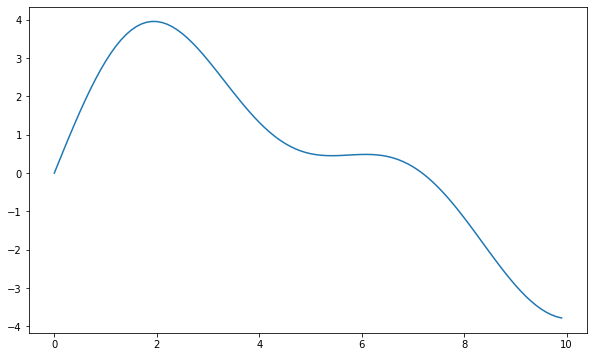

In [7]:
T = 100
t = np.arange(T)/T * 10
y_true = 3*np.sin(0.5*t) + 1.2*np.sin(1.0*t) + 0.5*np.sin(1.2*t) 
y = y_true + np.random.normal(size=T)
plt.figure(figsize=(10,6))
plt.plot(t,y_true)

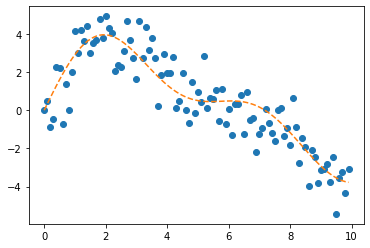

In [8]:
plt.plot(t,y,'o')
plt.plot(t,y_true,'--')

In [9]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

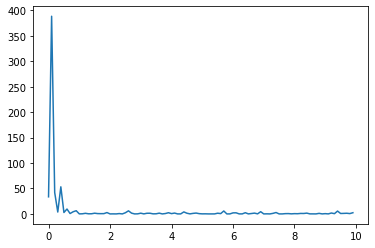

In [10]:
plt.plot(t,fbar**2) # periodogram 

In [11]:
fbar_threshed = ebayesthresh.ebayesthresh(fbar[:,0])

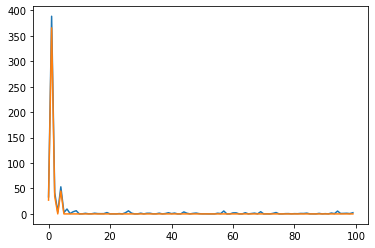

In [12]:
# fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 


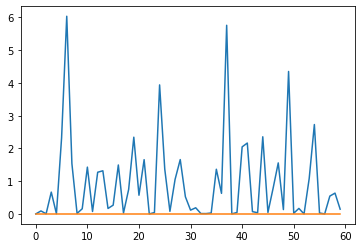

In [13]:
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

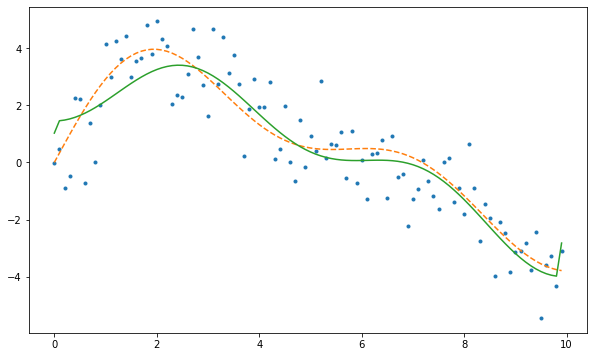

In [14]:
yhat = Psi @ fbar_threshed # inverse dft
plt.figure(figsize=(10,6))
plt.plot(t,y,'.')
plt.plot(t,y_true,'--')
plt.plot(t,yhat)

In [17]:
class ebayesthresh_nn(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,input):
        return ebayesthresh.ebayesthresh(input)

In [18]:
thresh_layer = ebayesthresh_nn()

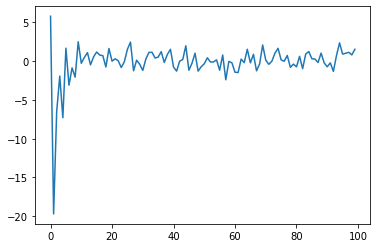

In [19]:
plt.plot(fbar[:,0])

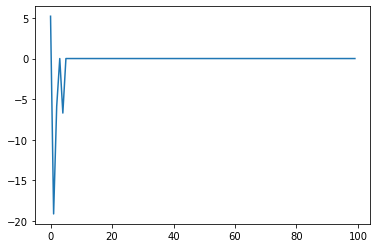

In [20]:
plt.plot(thresh_layer(fbar[:,0]))